## **Bayesian Bandits**

N slot machines, each with its own unknown probability
distribution for rewards. Exploration-exploitation tradeoff.

Let's model each machine as a Bernoulli random variable, each with its own probability of success:

In [0]:
import numpy as np

In [0]:
class machine:
  win, loss, srate = 0,0,0
  def __init__(self):
    self.srate = np.random.random()*.4+.3
  def play(self, times=1):
    n = int(times)
    for i in range(n):
      x = np.random.random()
      if x <= self.srate:
        self.win+=1
        print("You win!")
        return 1
      else:
        self.loss+=1
        print("You lose...")
        return 0
    
      
  

In [0]:
m1 = machine()
m2 = machine()
m3 = machine()
m4 = machine()
m5 = machine()

Now that we have our 5 machines (m1, m2, m3, m4 and m5), we can play each of them to test our luck.



In [0]:
m1.play()

You win!


1

In [0]:
m2.play()

You lose...


0

In [0]:
m3.play(10)

You lose...


0

No, not really! That's not the point!

We wish, in fact, to test for the parameters m1.srate, ..., m5.srate.

To do so, we need to establish prior distributions that match our belief on those parameters.

As we have no clue whether m1.srate < m2.srate or m3.srate > m4.srate and so on, we should use a unique prior for all the machines.

First, let's observe that playing each machine is like a Bernoulli trial with probability m.srate of success. 

Therefore, as each try should be independent from the others, the total number of successes in N tries should follow a Binomial distribution with parameters N and m.srate.

Well, if we are to estimate a binomial distribution, we'd better use a conjugate prior to make things fancier. The Beta distribution will do the trick.

Once again, we can assume we have no clue on the possible values of m.srate. They may be anything between 0 and 1. (In fact, if we peep into the machine code we'll see its restricted to the 0.3-0.7 interval.)

So, we may start with a Beta (2,2) as our prior, which is symetrical around the median 0.5 and somewhat concentrates our initial guess near it.

Let's plot it so we can see what's about:

In [0]:
>>> from scipy.stats import beta
>>> import matplotlib.pyplot as plt

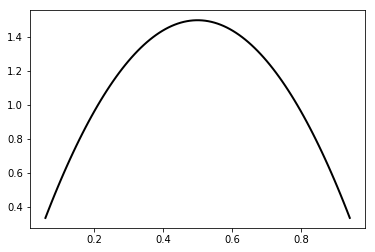

In [0]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, 2, 2),beta.ppf(0.99, 2, 2), 100)
rv = beta(2, 2)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
plt.show()

Now that we have our prior distribution, we can test the machines and update each distribution based on the outcomes they present to us.

First, let's restart the machines, so that our previous tries doesn't count.

In [0]:
m1 = machine()
m2 = machine()
m3 = machine()
m4 = machine()
m5 = machine()

Now, let's set the policy we'll follow in order to achieve our goal.

What do we understand for 'Exploration-exploitation tradeoff'?

Mainly, we have to balance our need to test and get data from each machine with our goal to win as much as possible.

So, what's the strategy?

Well...we may start with any of them, as they all have the same prior. As we test them, we'll get more information and update our priors into posteriors, which, in turn, will lead us to better guesses on which machine to choose next.

The algorithms will go like this:

//start turn
1. sample from all srate distributions
2. choose the machine corresponding to the highest sample
3. play that machine once
4. get the result (success or failure) and update that machine srate distribution

//end turn

The number of turns will be the total tries we'll wish to play until the end of the day.

In each turn, we'll decide which machine to play by chance, based on each machine srate distribution. Then we'll update that machine distribution based on the outcome. This means that each time we get a success, that machine will be more likely to be selected the next time. Conversly, if we get a failure, that machine will become less likely to be selected.

As turns go by, the distributions will become more concentrated around the mean rate successes/tries each machine presented thus far. So, the  samples will get less random and the (expected) best machine will be more likely to be chosen.

Hopefully, by the end of our playday, we'll have found the best machine and will be playing on it at every turn.  




Before we try to implement the algorithm, let's simulate the first turns to see what happens.



First turn:

//start turn

1. **sample from all srate distributions**
2. choose the machine corresponding to the highest sample
3. play that machine once
4. get the result (success or failure) and update that machine srate distribution

//end turn

Those distributions are all the same by now, so we could as well choose any we like.

Let's follow the policy anyway.


We will need to create a variable to keep recording the srand distribution of each machine.

In [0]:
class Beta():
  a, b = 0, 0
  pdf = beta(a,b).pdf
  def __init__(self,a,b):
    self.a, self.b = a, b
    self.pdf = beta(self.a,self.b).pdf
  def sample(self):
    return beta.rvs(self.a, self.b)
   


  

In [0]:
priori = [Beta(2, 2)]*5

Now, we sample from each machine priori to choose which one we will play first.

In [0]:
sample1 = [0]*5

for i in range(5):
  sample1[i] = priori[i].sample()
  
sample1

[0.4138924578618876,
 0.6815637789090548,
 0.6992740950464963,
 0.3530680201460371,
 0.5466636907073951]

Now we have to find the highest value sampled and pick the machine its sampled from.


//start turn

1. sample from all srate distributions
2. **choose the machine corresponding to the highest sample**
3. play that machine once
4. get the result (success or failure) and update that machine srate distribution

//end turn

In [0]:
print (max(sample1), sample1.index(max(sample1)))

0.6992740950464963 2


So, we have the max value sampled and the index of the sample in the array.

To make things easier, let's also index our machines in an array of machines:

In [0]:
machines = [m1,m2,m3,m4,m5]

Now, it's time we play the chosen machine and get the outcome:

//start turn

1. sample from all srate distributions
2. choose the machine corresponding to the highest sample
3. **play that machine once**
4. get the result (success or failure) and update that machine srate distribution

//end turn

In [0]:
outcome = machines[sample1.index(max(sample1))].play()

You lose...


Got lucky this time?

Well, it doesn't matter much, as we have a long playday ahead.

We have now to update that machine prior distribution based on the outcome.

But....how do we do that?

From Bayes Theorem we have:

* P(π|x) ∝ p(x|π) ⋅ p(π)

where p(π) is ou prior, P(π|x) is our posterior given the observation and p(x|π) is the likelihood of the observation.

In our case, our prior p(π) is Beta(2,2), while the likelihood p(x|π) follows a Ber(π) distribution. So, we have:

P(π|x) ∝  π^x * (1-π)^(1-x) * π^(2-1) * (1-π)^(2-1) = 

π^(2+x-1) * (1-π)^(2+1-x-1) ∝ Beta(2+x, 2+(1-x))

If x=1, i.e., we won, our posterior is now Beta(3,2).

If x=0, i.e., we lost, our posterior is now Beta(2,3).

Let's update our prior based on the outcome we had.

//start turn

1. sample from all srate distributions
2. choose the machine corresponding to the highest sample
3. play that machine once
4. **get the result (success or failure) and update that machine srate distribution**

//end turn

In [0]:
priori[sample1.index(max(sample1))]=Beta(2+outcome,2+1-outcome)

for prior in priori:
  print('Beta(',prior.a,',',prior.b,')')

Beta( 2 , 2 )
Beta( 2 , 2 )
Beta( 2 , 3 )
Beta( 2 , 2 )
Beta( 2 , 2 )


We've finally finished the very first turn!

Now we have updated one of the priors, the one from the machine we played on. But we still have a Beta (2,2) for each of the other machines.

So, let's go for the second turn. Only, this time, we'll do all the steps at once. 

In [0]:
sample2 = [0]*5

for i in range(5):
  sample2[i] = priori[i].sample()
  
sample2

[0.9114788364767801,
 0.23104410672568912,
 0.7162816653556184,
 0.1874894710658092,
 0.2897988143366392]

In [0]:
outcome = machines[sample2.index(max(sample2))].play()

You lose...


In [0]:
a = priori[sample2.index(max(sample2))].a
b = priori[sample2.index(max(sample2))].b
priori[sample2.index(max(sample2))]=Beta(a+outcome,b+1-outcome)

for prior in priori:
  print('Beta(',prior.a,',',prior.b,')')

Beta( 2 , 3 )
Beta( 2 , 2 )
Beta( 2 , 3 )
Beta( 2 , 2 )
Beta( 2 , 2 )


We are doing great!

One more turn:

In [0]:
sample = [0]*5

for i in range(5):
  sample[i] = priori[i].sample()
  
sample

[0.31298085455828667,
 0.40676448580222796,
 0.2178315830638713,
 0.9752069732933262,
 0.7658524634804499]

In [0]:
outcome = machines[sample.index(max(sample))].play()

You lose...


In [0]:
a = priori[sample.index(max(sample))].a
b = priori[sample.index(max(sample))].b
priori[sample.index(max(sample))]=Beta(a+outcome,b+1-outcome)

for prior in priori:
  print('Beta(',prior.a,',',prior.b,')')

Beta( 2 , 3 )
Beta( 2 , 2 )
Beta( 2 , 3 )
Beta( 2 , 3 )
Beta( 2 , 2 )


Three done! Good!

Well...I think it's time to make things faster.

How about inserting a code to automate it and then simulate the proccess for, say, 1000 times?

Go for it!

In [0]:
#def play_machines(n):
  #your code here
  

In [0]:
play_machines(997)

Got it?

Now...how do we measure how good is our strategy?

Well, our goal is to maximize the winnings, so, maybe, we should compare our outcome with the 'playing the best machine' strategy?

If we sum the total wins we achieved and match it with the expected total wins by playing the best machine the same amount of tries, that would be a good measure.

But, we haven't summed it up, have we?

Fortunately, we can access the winnings on each machine, as they keep that number as an attribute.

Let's do it!

In [0]:
total_wins = 0

for machine in machines:
  total_wins += machine.win
  
total_wins

584

Now, let's check the expected wins for the best machine.

In [0]:
total_tries = 0
best_rate = 0

for machine in machines:
  total_tries += (machine.win+machine.loss)
  if best_rate < machine.srate:
    best_rate = machine.srate
  
expect_wins = total_tries * best_rate
print (total_tries, best_rate, expect_wins)

1000 0.6435286196053108 643.5286196053108


So, now, what could be our metric?

How about the ratio "our wins / best machine wins"?

Sounds good to me.

In [0]:
strategy_rate = total_wins / expect_wins

print ("O desempenho relativo da nossa estratégia foi de ", round(strategy_rate*100,2),"%.")

O desempenho relativo da nossa estratégia foi de  90.75 %.


Good enough for you?

Not sure we could have done better not knowing which machine was the best one.

Anyway, the longer the playday, the closer to the best strategy our strategy should work.

Why don't we try to play the machines until we reach 10000 times?

In [0]:
#play_machines(9000):
  

In [0]:
total_wins = 0
total_tries = 0
best_rate = 0

for machine in machines:
  total_wins += machine.win
  total_tries += (machine.win+machine.loss)
  if best_rate < machine.srate:
    best_rate = machine.srate  
  
expect_wins = total_tries * best_rate
strategy_rate = total_wins / expect_wins

print (total_wins, total_tries, best_rate, expect_wins)
print ("O desempenho relativo da nossa estratégia foi de ", round(strategy_rate*100,2),"%.")

6270 10000 0.6435286196053108 6435.286196053108
O desempenho relativo da nossa estratégia foi de  97.43 %.


Is it closer to 100%?

Finally, let's insert a function to plot our distributions and see how they evolve throghout the process. 

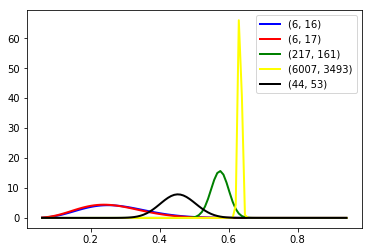

In [0]:
def plot_betas(priori):
  fig, ax = plt.subplots(1, 1)
  x = np.linspace(beta.ppf(0.01, 2, 2),beta.ppf(0.99, 2, 2), 100)
  colors = ['blue','red','green','yellow','black']
  i=0
  legend =[]
  for prior in priori:  
    ax.plot(x, prior.pdf(x), 'k-', lw=2, label='frozen pdf', color = colors[i])
    legend.append((prior.a,prior.b))
    i+=1
  ax.legend(legend)
  plt.show()
  
plot_betas(priori)

Now, modify your "play_machines" function, so that it calls the "plot_betas" function on some iterations.

You may choose that iterations by setting a "plots" array with the numbers 1, 5, 20, 50, 100, 250, 500, 1000. Then, the "plot_betas" function shall be called whenever an iteration is in the array plots.

Also, comment the 'print' command lines in the Machine class, so that the plots won't get lost among all the prints.

Let's restart all the machines and run the playday one last time.

In [0]:
class machine:
  win, loss, srate = 0,0,0
  def __init__(self):
    self.srate = np.random.random()*.4+.3
  def play(self, times=1):
    n = int(times)
    for i in range(n):
      x = np.random.random()
      if x <= self.srate:
        self.win+=1
        #print("You win!")
        return 1
      else:
        self.loss+=1
        #print("You lose...")
        return 0

In [0]:
m1 = machine()
m2 = machine()
m3 = machine()
m4 = machine()
m5 = machine()

machines = [m1,m2,m3,m4,m5]
priori = [Beta(2,2)]*5

play_machines(1000)